In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score

In [27]:
df = pd.read_csv("radiomics_features.csv")

# Add label: 0 = benign, 1 = malignant
df["label"] = df["ID"].apply(lambda x: 0 if "benign" in x.lower() else 1)

# Remove diagnostic columns. Radiomics generates many "diagnostics_" columns that contain metadata, not features
df = df.loc[:, ~df.columns.str.startswith("diagnostics_")]

# Prepare X and y
y = df["label"] # target variable x and y
X = df.drop(columns=["ID", "label"]) # all radiomics features

In [28]:
print(f"Number of images: {X.shape[0]}")
print(f"Number of benign images: {len(y[y==0])}")
print(f"Number of malignant images: {len(y[y==1])}")

Number of images: 645
Number of benign images: 437
Number of malignant images: 208


In [29]:
df = pd.read_csv("radiomics_features.csv") 

# Create Label: 0 = benign, 1 = malignant
df["label"] = df["ID"].apply(lambda x: 0 if "benign" in x.lower() else 1)

# Remove "diagnostics_" columns and ID
df_clean = df.loc[:, ~df.columns.str.startswith("diagnostics_")]
X = df_clean.drop(columns=["ID", "label"])
y = df_clean["label"]

# Scale the data GLOBALLY for the optimization step
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

model_config = {
    "Logistic Regression (Lasso)": {
        "model": LogisticRegression(solver='liblinear', random_state=42),
        "params": {
            'C': np.logspace(-2, 2, 10),     
            'penalty': ['l1']       
        }
    },
    "Linear SVM (Lasso)": {
        # dual=False is required when penalty='l1' for LinearSVC
        "model": LinearSVC(penalty='l1', dual=False, random_state=42),
        "params": {
            # C controls regularization: Smaller C = fewer features (more sparsity)
            'C': np.logspace(-2, 1, 10) 
        }
    },
    "Random Forest (Imp. Selected)": {
        "model": Pipeline([
            ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
            ('clf', RandomForestClassifier(random_state=42))
        ]),
        "params": {
            'selector__threshold': ['mean', '1.25*mean'], 
            'clf__n_estimators': [100],  
            'clf__max_depth': [3, 5]
        }
    },
    "Naive Bayes (Selected)": {
        "model": Pipeline([
            ('selector', SelectKBest(f_classif)),
            ('clf', GaussianNB())
        ]),
        "params": {
            'selector__k': [3, 5, 10, 15, 30],     
            'clf__var_smoothing': np.logspace(-9, -2, 5)
        }
    }
}

best_models = {}

for name, config in model_config.items():
    print(f"Optimizing {name}...")
    gs = GridSearchCV(config["model"], config["params"], cv=3, scoring='roc_auc', n_jobs=-1)
    gs.fit(X_scaled, y)
    best_models[name] = gs.best_estimator_

final_results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in best_models.items():
    
    # Storage for metrics per fold
    fold_aucs = []
    fold_accs = []   
    fold_precs = []  
    fold_feats = []
    
    # Run 5-Fold CV on the BEST model
    for train_idx, val_idx in cv.split(X_scaled, y):
        X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_val)[:, 1]
        else:
            y_prob = model.decision_function(X_val) # For SVM if prob=False
            
        y_pred = model.predict(X_val)
        
        # Calculate Metrics
        try:
            auc = roc_auc_score(y_val, y_prob)
        except:
            auc = 0.5 # Handle edge cases
            
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, zero_division=0)
        
        fold_aucs.append(auc)
        fold_accs.append(acc)
        fold_precs.append(prec)
        
        # 1. Pipeline (Naive Bayes)
        if isinstance(model, Pipeline):
            # Is it SelectKBest?
            if 'selector' in model.named_steps:
                selector = model.named_steps['selector']
                if hasattr(selector, 'k'): # SelectKBest
                    n_feats = selector.k if selector.k != 'all' else X_train.shape[1]
                elif hasattr(selector, 'get_support'): # SelectFromModel (SVM/RF)
                    n_feats = np.sum(selector.get_support())
                else:
                    n_feats = X_train.shape[1]
            
        # 2. Linear Models (Lasso, Linear SVM)
        elif hasattr(model, "coef_"):
            if model.coef_.ndim > 1:
                n_feats = np.sum(model.coef_[0] != 0)
            else:
                n_feats = np.sum(model.coef_ != 0)
        
        # 3. Tree Models (Random Forest)
        elif hasattr(model, "feature_importances_"):
            n_feats = np.sum(model.feature_importances_ > 0)
            
        # 4. Fallback (Non-linear SVM with RBF kernel uses all features)
        else:
            n_feats = X_train.shape[1]
            
        fold_feats.append(n_feats)

    # Aggregating Results
    final_results.append({
        "Model": name,
        "Best Params": str(model.get_params()['C']) if 'C' in model.get_params() else "N/A",
        "Mean AUC": f"{np.mean(fold_aucs):.3f} ± {np.std(fold_aucs):.3f}",
        "Mean Accuracy": f"{np.mean(fold_accs):.3f}",   
        "Mean Precision": f"{np.mean(fold_precs):.3f}",  
        "Avg Features Used": f"{np.mean(fold_feats):.1f}"
    })

results_df = pd.DataFrame(final_results)
print(results_df[["Model", "Mean AUC", "Mean Accuracy", "Mean Precision", "Avg Features Used"]])

Optimizing Logistic Regression (Lasso)...
Optimizing Linear SVM (Lasso)...
Optimizing Random Forest (Imp. Selected)...


/Users/abby/miniforge3/envs/radiomics/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/abby/miniforge3/envs/radiomics/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/abby/miniforge3/envs/radiomics/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/abby/miniforge3/envs/radiomics/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/abby/miniforge3/envs/radiomics/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/abby/miniforg

Optimizing Naive Bayes (Selected)...


/Users/abby/miniforge3/envs/radiomics/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/abby/miniforge3/envs/radiomics/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                           Model       Mean AUC Mean Accuracy Mean Precision  \
0    Logistic Regression (Lasso)  0.983 ± 0.006         0.955          0.953   
1             Linear SVM (Lasso)  0.984 ± 0.006         0.958          0.958   
2  Random Forest (Imp. Selected)  0.958 ± 0.021         0.921          0.955   
3         Naive Bayes (Selected)  0.863 ± 0.015         0.802          0.676   

  Avg Features Used  
0              22.0  
1              29.4  
2              19.0  
3               5.0  


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'C': np.float64(1.2742749857031335), 'penalty': 'l1', 'solver': 'liblinear'}


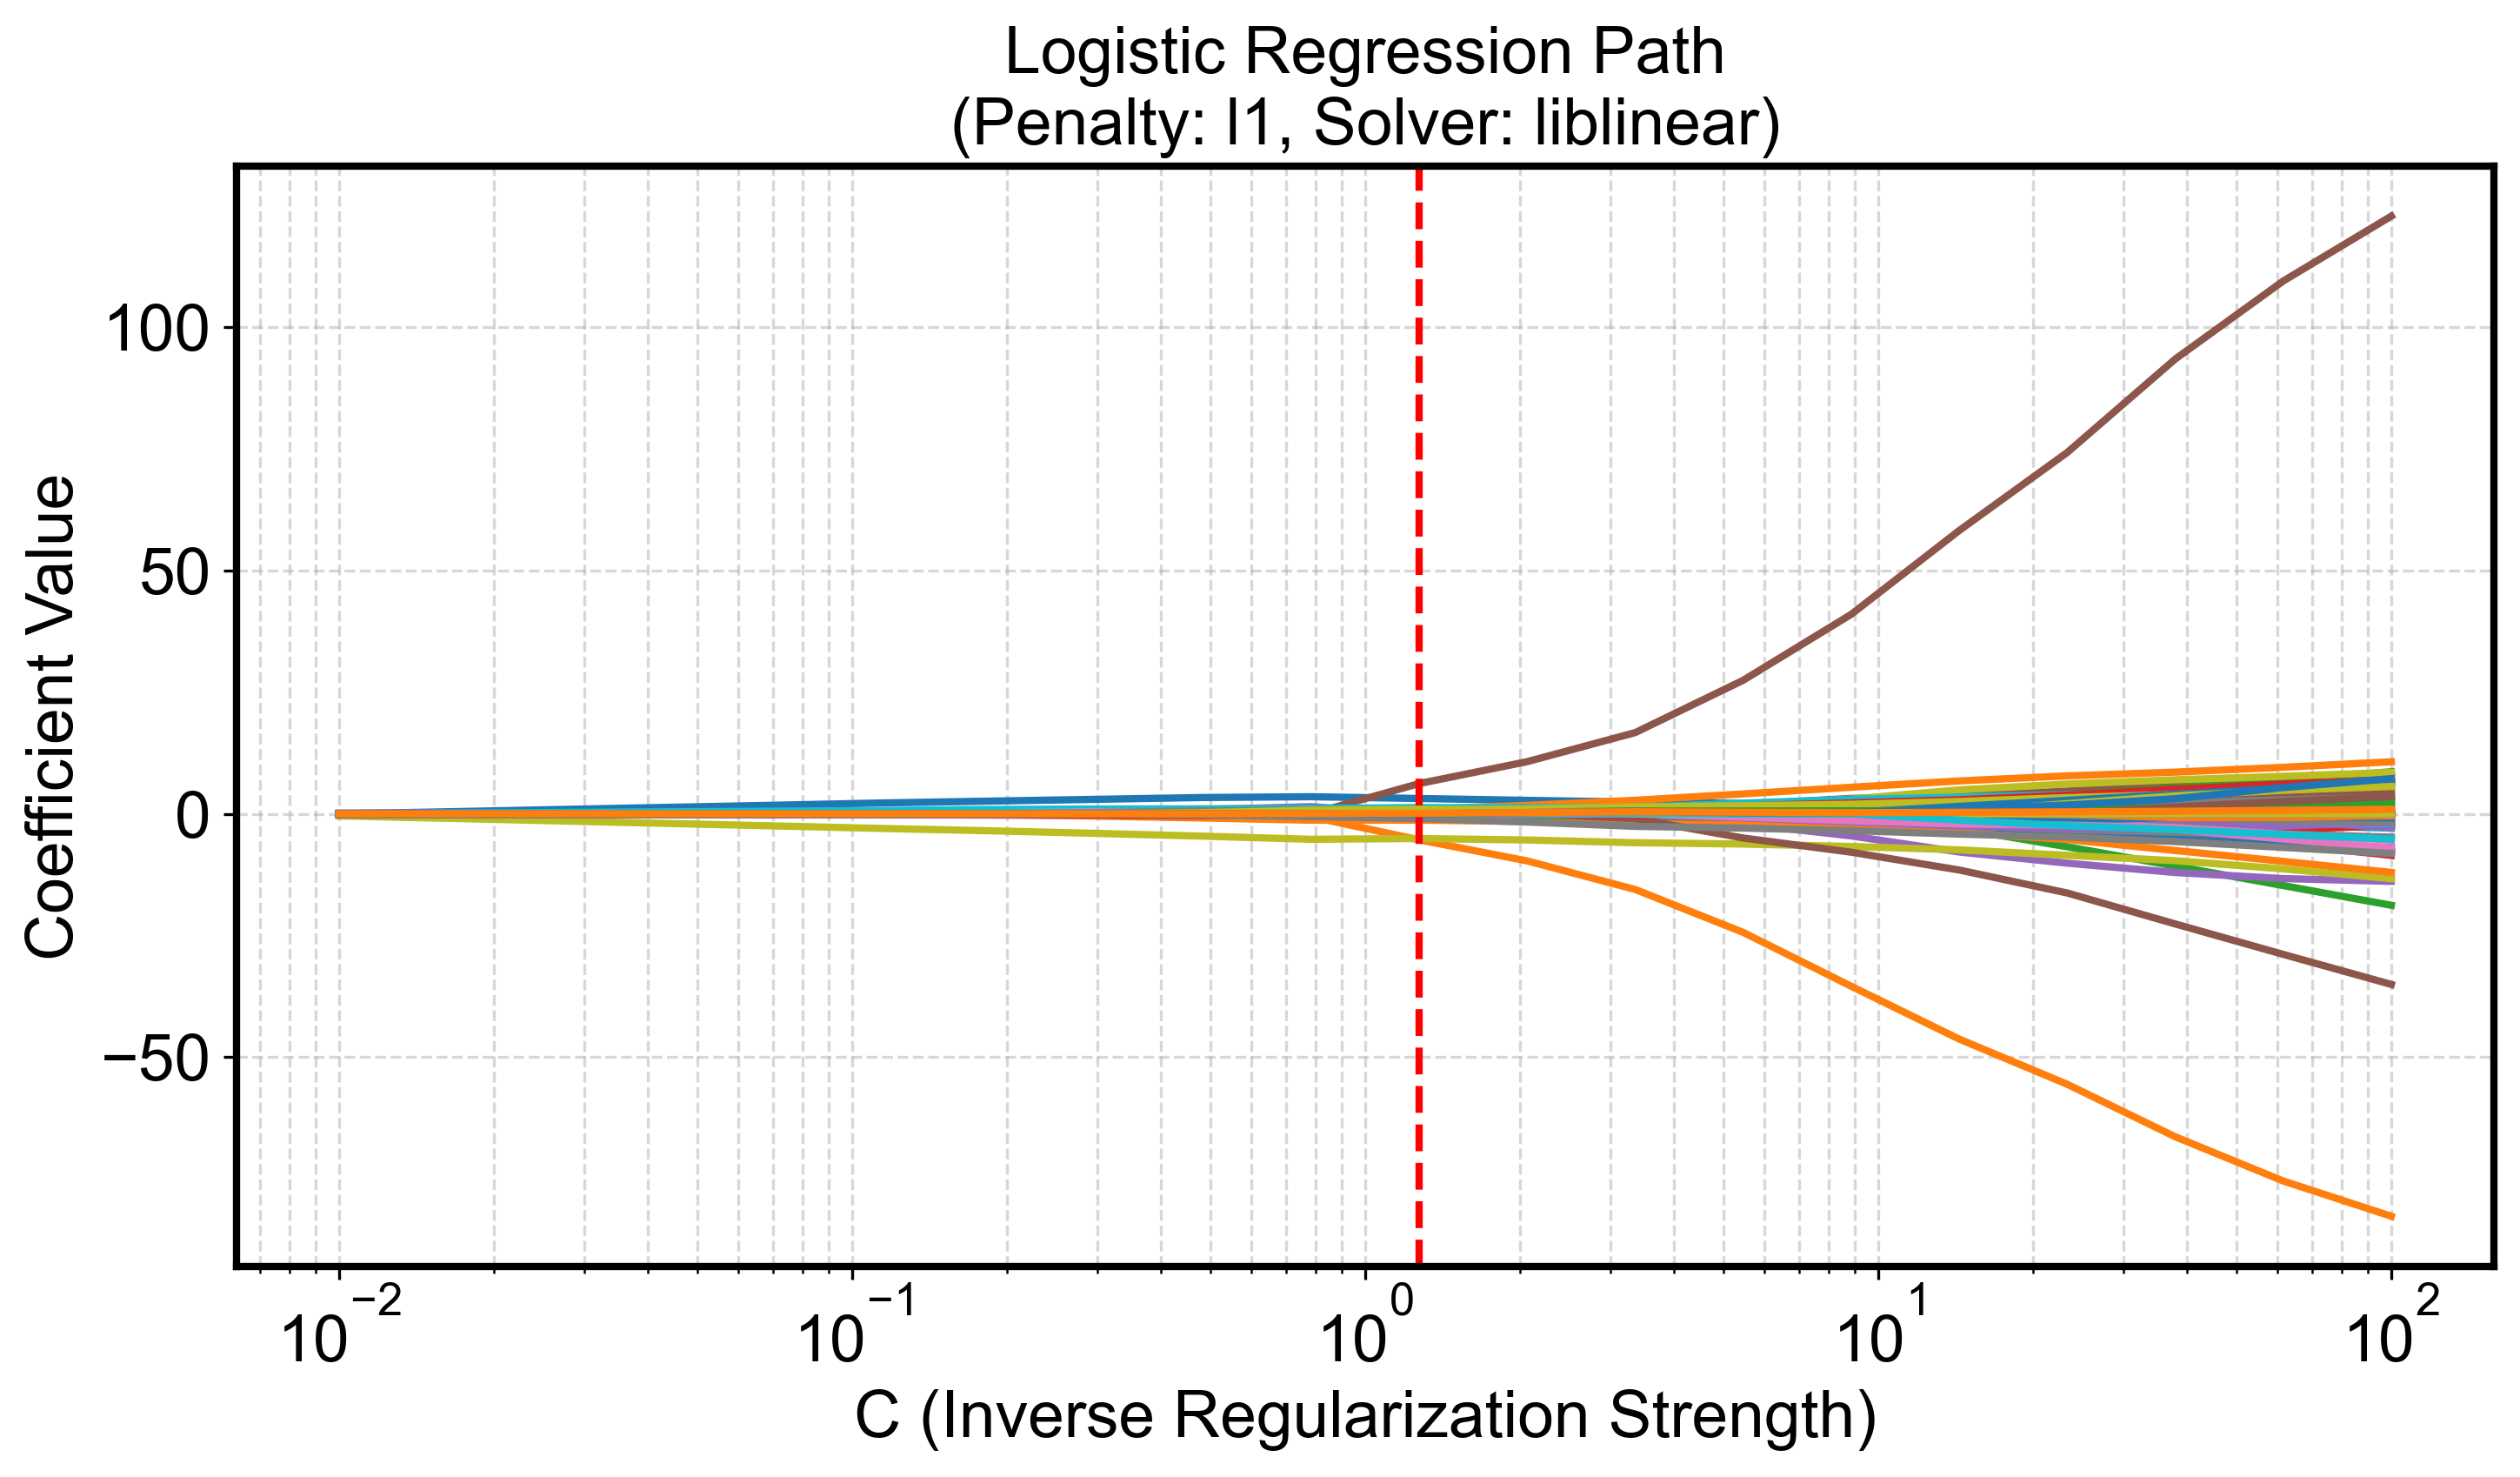

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

param_grid = {
    'C': np.logspace(-2, 2, 20), 
    'solver': ['liblinear'],      
    'penalty': ['l1']
}

log_reg = LogisticRegression(max_iter=5000)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_scaled, y)

print("Best Params:", grid_search.best_params_)
best_penalty = grid_search.best_params_['penalty']
best_solver = grid_search.best_params_['solver']


C_values = param_grid['C']
coef_list = []

print("Collecting coefficients for plot...")

for c in C_values:
    # Initialize model with specific C and best other params
    clf = LogisticRegression(
        C=c, 
        penalty=best_penalty, 
        solver=best_solver, 
        max_iter=5000,
        random_state=42
    )
    clf.fit(X_scaled, y)
    
    coef_list.append(clf.coef_.flatten())


coef_array = np.array(coef_list)

plt.figure(figsize=(10, 6))

for i in range(coef_array.shape[1]):
    plt.plot(C_values, coef_array[:, i], label=X.columns[i])

plt.xscale('log') 
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title(f'Logistic Regression Path\n(Penalty: {best_penalty}, Solver: {best_solver})')
plt.axvline(grid_search.best_params_['C'], color='red', linestyle='--', label='Best C (GridSearch)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

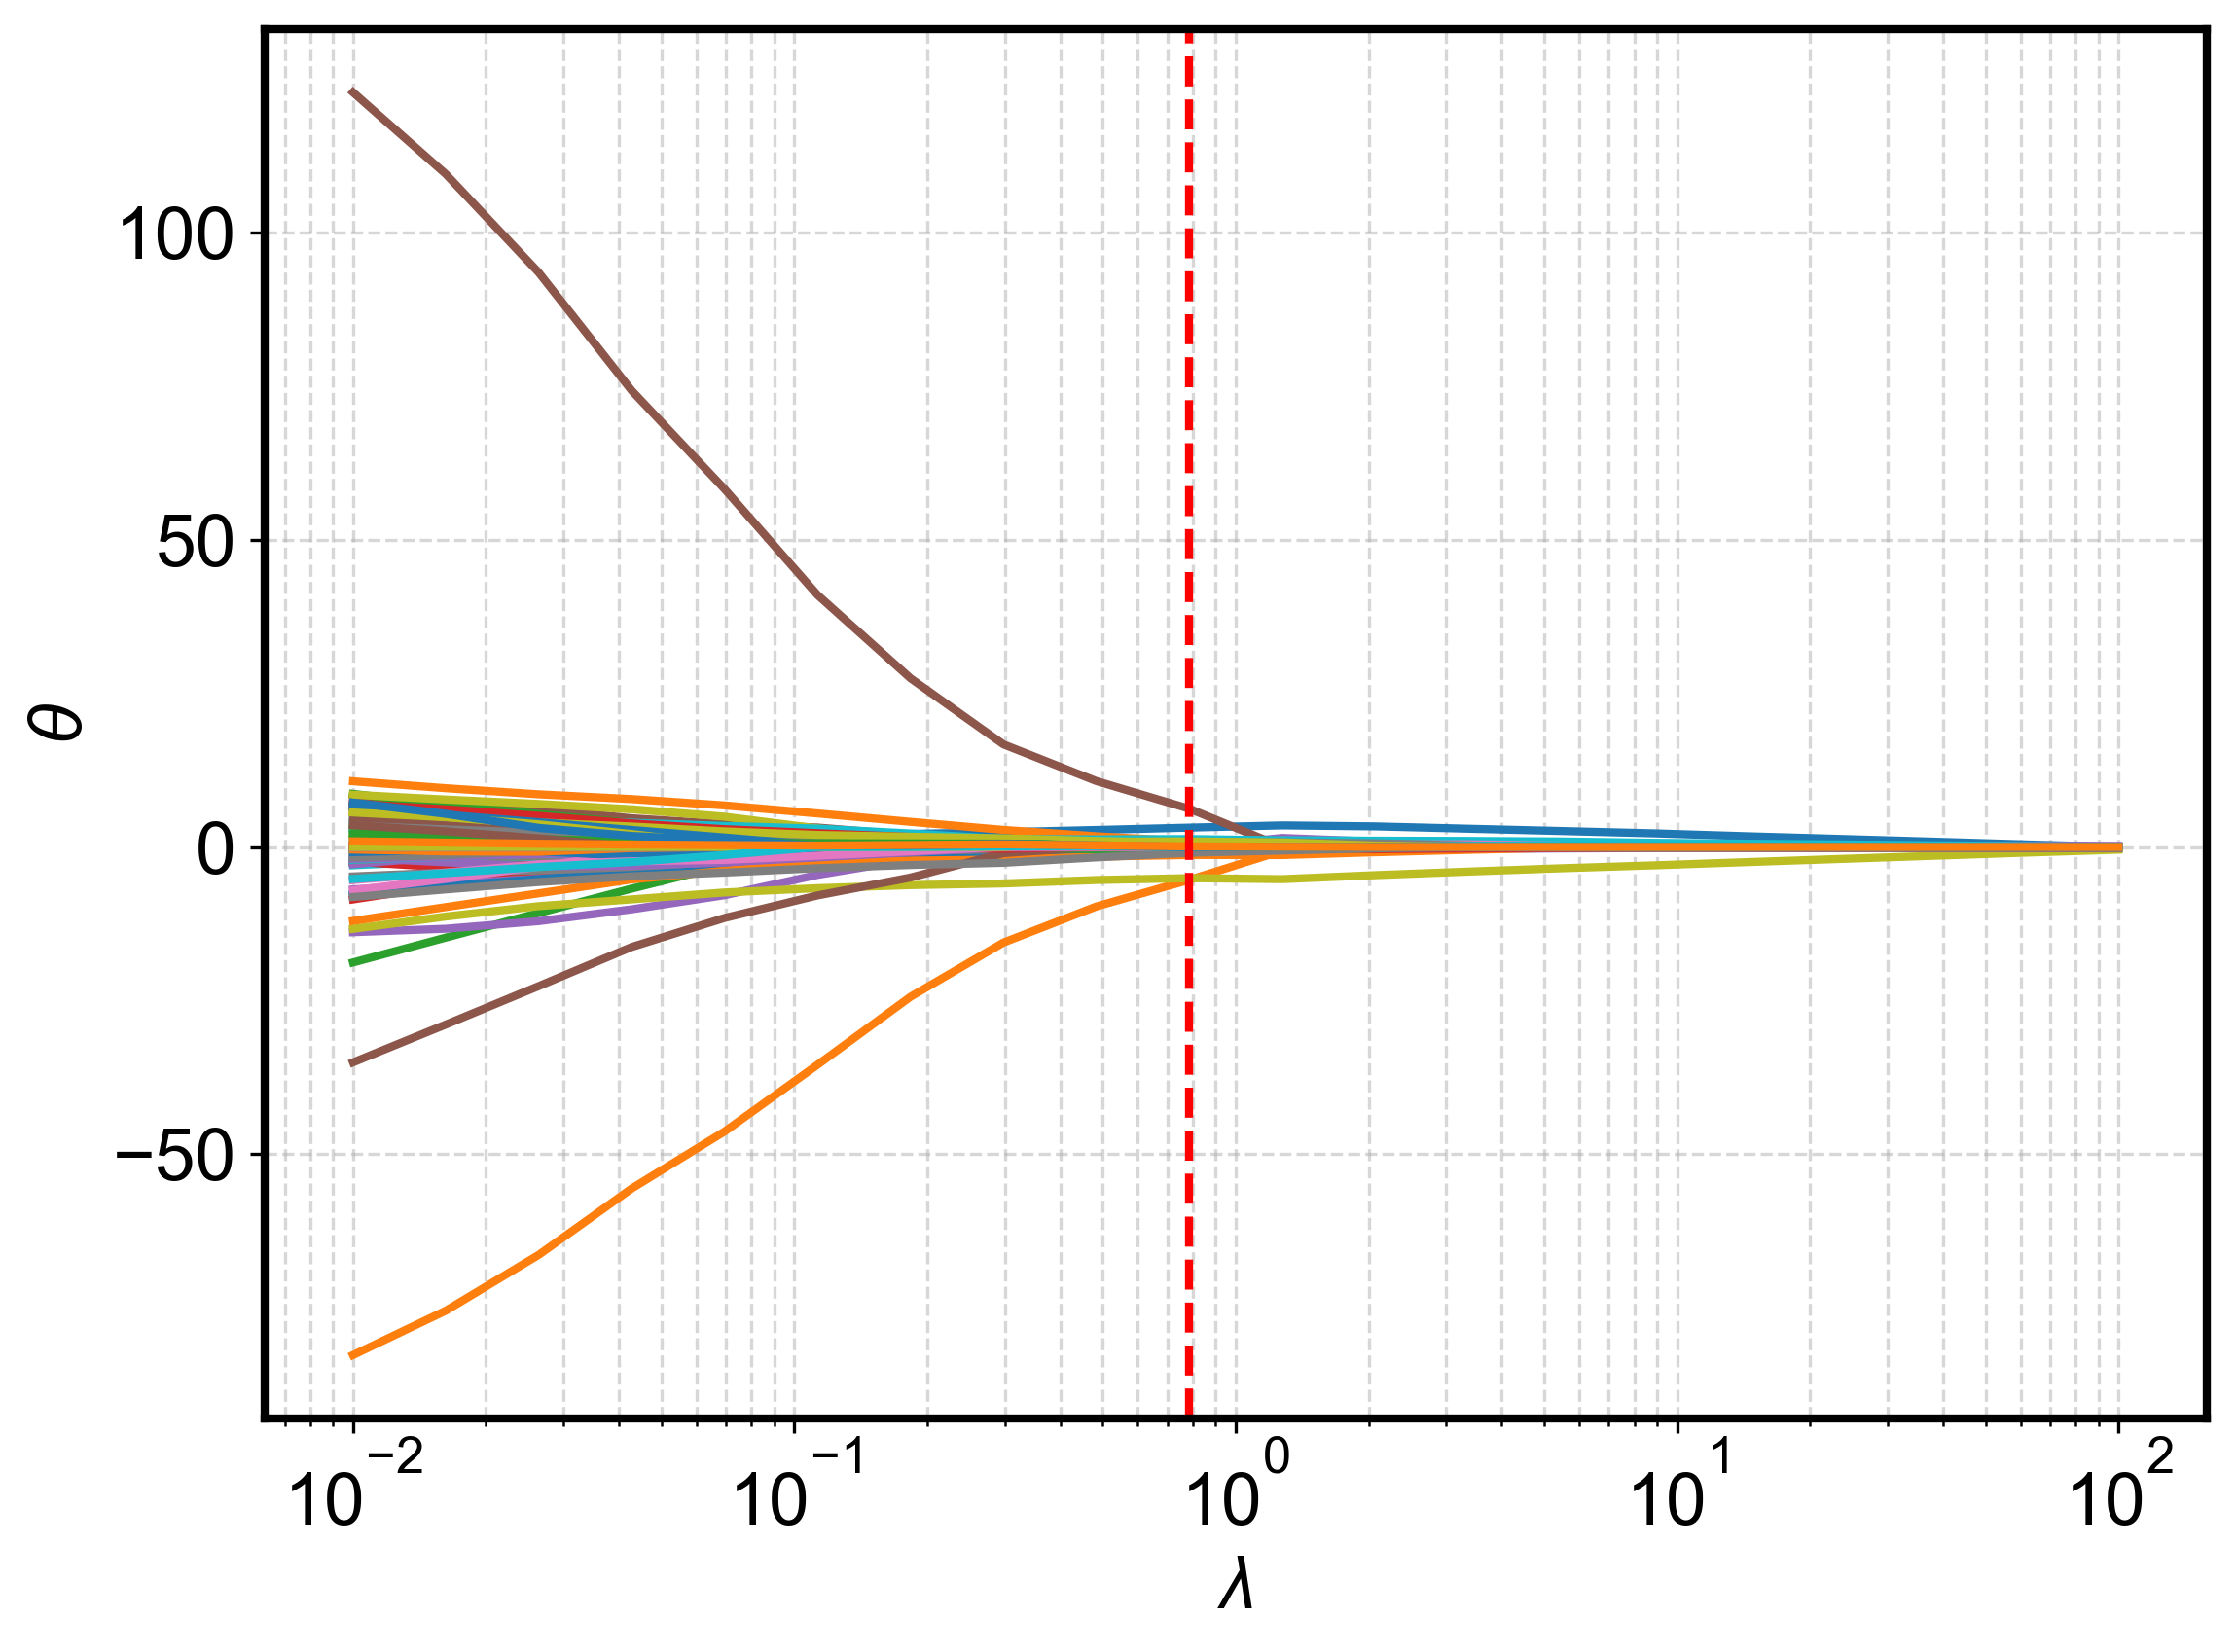

In [43]:
font_name = 'Arial'
plt.rcParams.update({
    'font.sans-serif': 'Arial',
    'font.size': 18,
    'axes.labelsize': 18,     
    'axes.titlesize': 18,    
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'lines.linewidth': 2,
    'axes.linewidth': 2,
    'grid.linewidth': 0.8,
    'figure.dpi': 300,
    'mathtext.fontset': 'custom',
    'mathtext.rm': font_name,
    'mathtext.it': f'{font_name}:italic',
    'mathtext.bf': f'{font_name}:bold',
})

lambdas = 1 / np.array(C_values)

plt.figure(figsize=(8, 6))

# Loop over features
for i in range(coef_array.shape[1]):
    plt.plot(lambdas, coef_array[:, i], label=X.columns[i])

# Set X-axis to Log Scale so it's readable
plt.xscale('log') 
plt.xlabel('$\lambda$')
plt.ylabel(r'$\theta$')

# Add vertical line for the best model
best_lambda = 1 / grid_search.best_params_['C']
plt.axvline(best_lambda, color='red', linestyle='--', label=f'Optimal $\lambda$ = {best_lambda:.4f}')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Model Intercept: [-0.8397874]
Non-zero coefficients: 32

--- Top 10 Selected Features ---
                                            Feature  Coefficient
5                        original_shape2D_Perimeter     6.202376
1                  original_shape2D_MajorAxisLength    -5.352212
8                       original_shape2D_Sphericity    -5.082283
0                       original_shape2D_Elongation     3.150678
61  original_glrlm_RunLengthNonUniformityNormalized    -1.310105
59                        original_glrlm_RunEntropy     1.287610
57       original_glrlm_LongRunLowGrayLevelEmphasis    -1.009932
97                          original_ngtdm_Busyness    -0.953074
51            original_glrlm_GrayLevelNonUniformity     0.922115
98                        original_ngtdm_Coarseness     0.912417


/var/folders/99/h1_0328j38b3_jqfrqbgt12m0000gn/T/ipykernel_16775/2112370733.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=plot_data, palette='viridis')


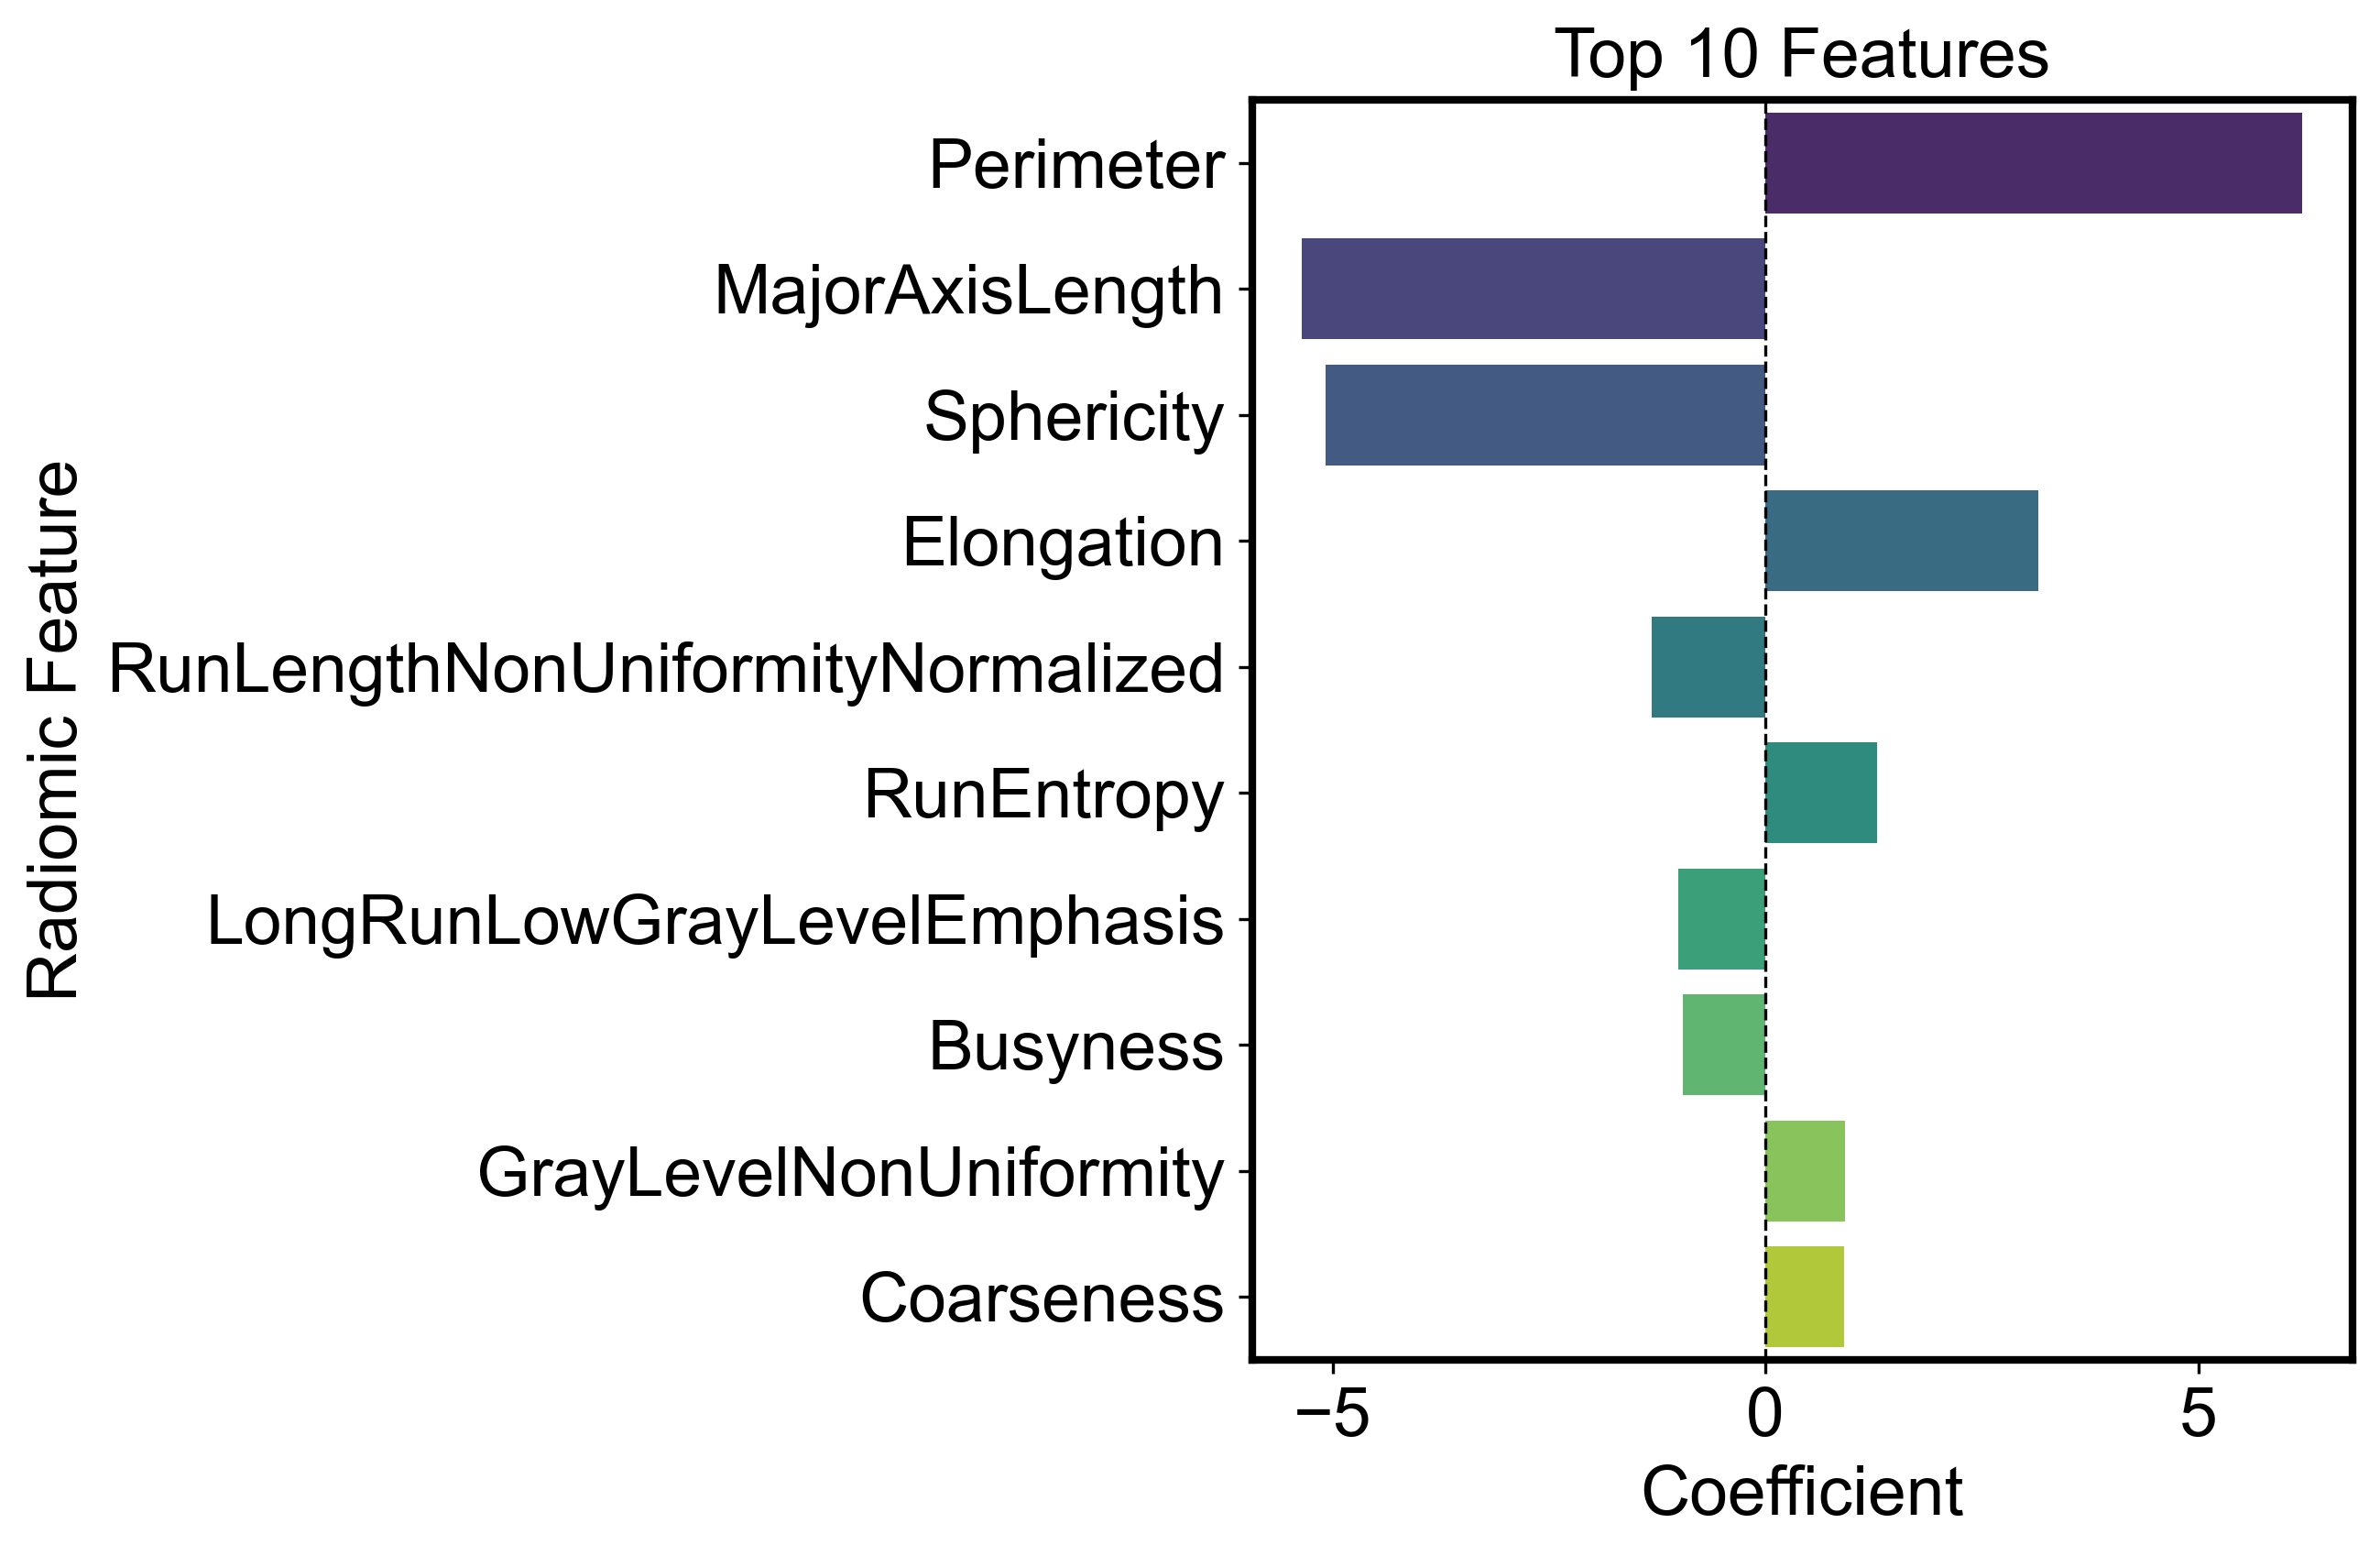

In [ ]:
best_model = grid_search.best_estimator_

coefs = best_model.coef_.flatten()

print(f"Model Intercept: {best_model.intercept_}")
print(f"Non-zero coefficients: {np.sum(coefs != 0)}")

feature_results = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefs
})

# Filter for "survivors" (magnitude > 1e-5 to handle float precision)
selected_features_df = feature_results[feature_results['Coefficient'].abs() > 1e-5].copy()

# Sort by importance
selected_features_df['Abs_Coeff'] = selected_features_df['Coefficient'].abs()
selected_features_df = selected_features_df.sort_values(by='Abs_Coeff', ascending=False)

df_selected = X[selected_features_df['Feature']].copy()
df_selected['Target'] = y  

print("\n--- Top 10 Selected Features ---")
print(selected_features_df[['Feature', 'Coefficient']].head(10))


top_n = 10
plot_data = selected_features_df.head(top_n).copy()

# Clean names
plot_data['Feature'] = plot_data['Feature'].apply(lambda x: x.split('_')[-1])

plt.figure(figsize=(9, 6))
sns.barplot(x='Coefficient', y='Feature', data=plot_data, palette='viridis')

plt.title(f'Top {top_n} Features')
plt.xlabel('Coefficient')
plt.ylabel('Radiomic Feature')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

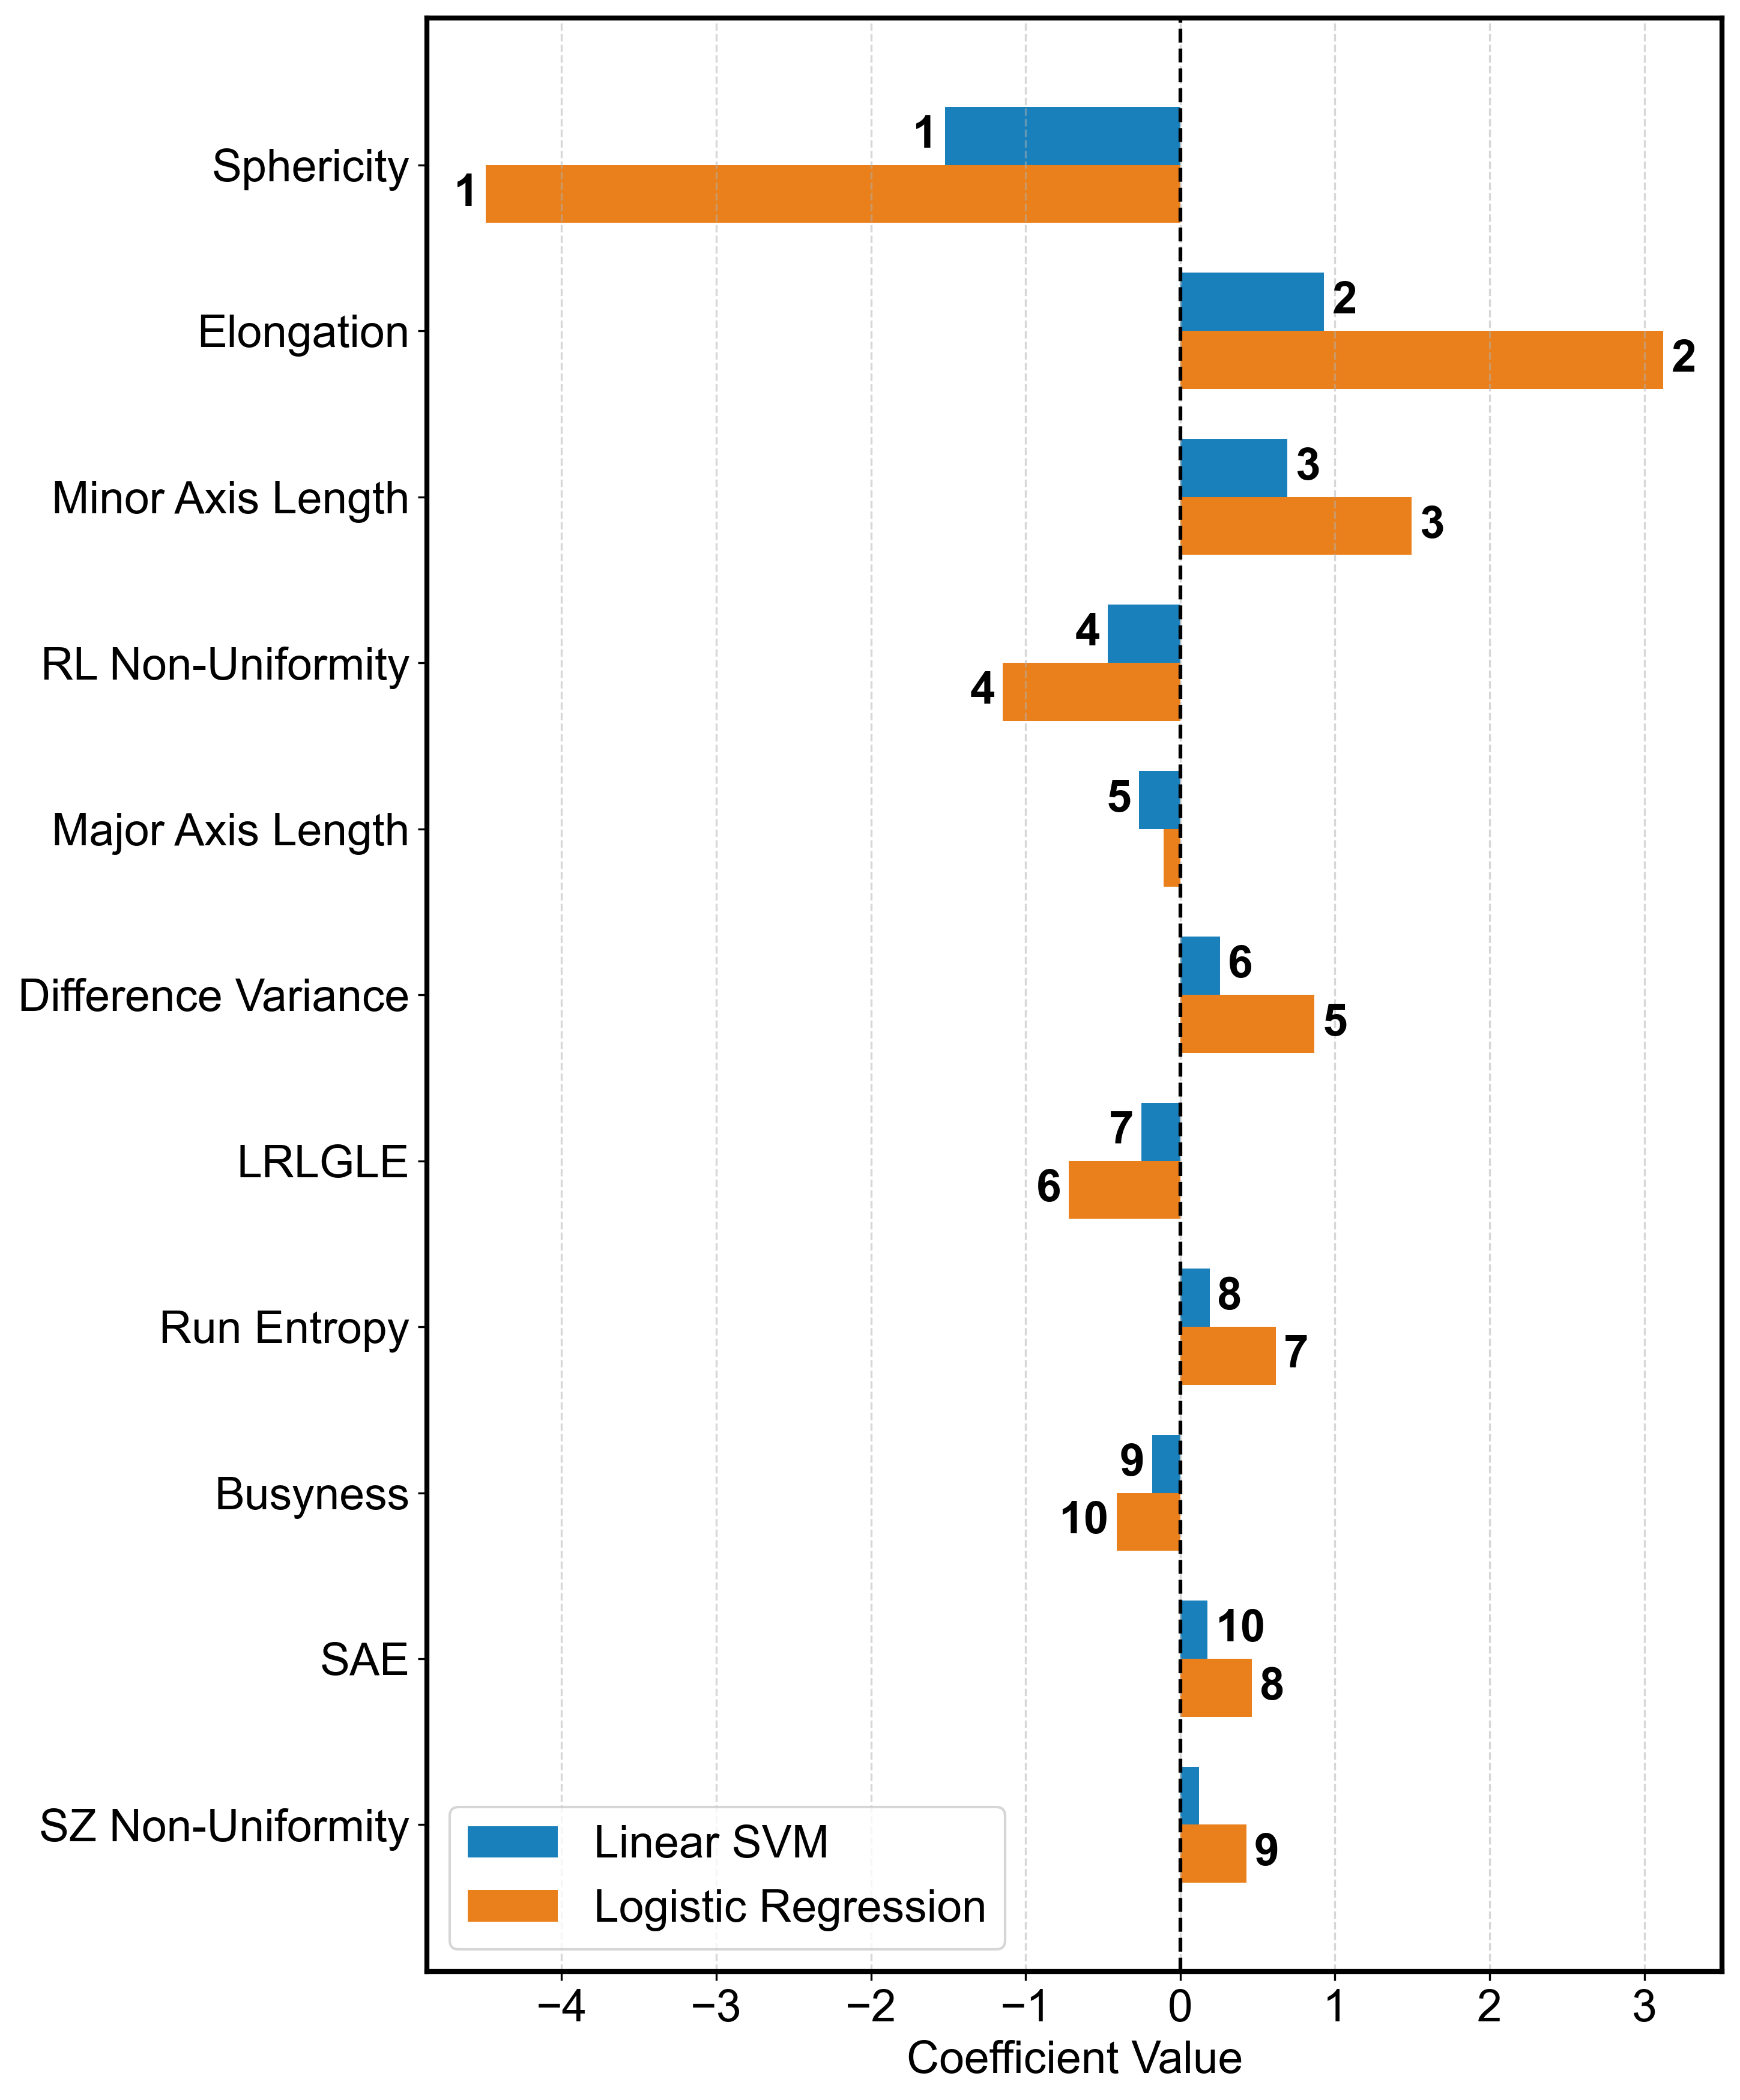

In [59]:
def get_coeffs(model_or_pipeline, model_name, feature_names):
    if hasattr(model_or_pipeline, "named_steps"):
        if 'clf' in model_or_pipeline.named_steps:
            model = model_or_pipeline.named_steps['clf']
        else:
            model = model_or_pipeline.named_steps['model']
    else:
        model = model_or_pipeline
        
    if hasattr(model, "coef_"):
        coeffs = model.coef_.flatten()
        return pd.Series(coeffs, index=feature_names, name=model_name)
    else:
        return pd.Series(0, index=feature_names, name=model_name)
    
RENAME_MAP = {
    'Sphericity': 'Sphericity',
    'Elongation': 'Elongation',
    'MinorAxisLength': 'Minor Axis Length',
    'RunLengthNonUniformityNormalized': 'RL Non-Uniformity',
    'MajorAxisLength': 'Major Axis Length',
    'DifferenceVariance': 'Difference Variance',
    'LongRunLowGrayLevelEmphasis': 'LRLGLE',
    'RunEntropy': 'Run Entropy',
    'Busyness': 'Busyness',
    'SmallAreaEmphasis': 'SAE',
    'SizeZoneNonUniformityNormalized': 'SZ Non-Uniformity'
}

feature_names = X.columns 
svm_series = get_coeffs(best_models["Linear SVM (Lasso)"], "Linear SVM", feature_names)
lr_series = get_coeffs(best_models["Logistic Regression (Lasso)"], "Logistic Regression", feature_names)

# ranks
svm_ranks = svm_series.abs().rank(ascending=False, method='min')
lr_ranks = lr_series.abs().rank(ascending=False, method='min')

top_10_svm_names = svm_series.abs().nlargest(10).index
top_10_lr_names = lr_series.abs().nlargest(10).index
combined_features = top_10_svm_names.union(top_10_lr_names)

plot_df = pd.DataFrame({
    "Linear SVM": svm_series[combined_features],
    "Logistic Regression": lr_series[combined_features],
    "SVM_Rank": svm_ranks[combined_features],
    "LR_Rank": lr_ranks[combined_features]
})

plot_df["sort_val"] = plot_df["Linear SVM"].abs()
plot_df = plot_df.sort_values("sort_val", ascending=True).drop(columns="sort_val")

# rename
plot_df.index = plot_df.index.map(lambda x: x.split('_')[-1])
plot_df.index = plot_df.index.map(lambda x: RENAME_MAP.get(x, x))

fig, ax = plt.subplots(figsize=(10, 12)) 
y = np.arange(len(plot_df))
height = 0.35

# Draw Bars
rects1 = ax.barh(y + height/2, plot_df["Linear SVM"], height, label="Linear SVM", color="#1a80bb")
rects2 = ax.barh(y - height/2, plot_df["Logistic Regression"], height, label="Logistic Regression", color="#ea801c")

def label_bars(rects, ranks, ax):
    for rect, rank in zip(rects, ranks):
        width = rect.get_width()
        
        if rank <= 10:
            label_text = f"{int(rank)}"
            
            xloc = width
            if width < 0: 
                align = 'right'
                offset = -0.05 
            else:
                align = 'left'
                offset = 0.05
                
            ax.text(xloc + offset, rect.get_y() + rect.get_height()/2, label_text,
                    ha=align, va='center', color='black', fontsize=18, fontweight='bold') 

label_bars(rects1, plot_df["SVM_Rank"], ax)
label_bars(rects2, plot_df["LR_Rank"], ax)

ax.set_yticks(y)
ax.set_yticklabels(plot_df.index)
ax.axvline(0, color="black", linewidth=1.5, linestyle="--")
ax.set_xlabel("Coefficient Value")
ax.legend(loc='lower left') 
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()